# Create and save average characteristic maps

## Open data

In [2]:
import os
import pickle
from pathlib import Path
from datetime import datetime, date

import xarray as xr
import rioxarray
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

In [3]:
SAVE_FIGS = True
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')
REPO_ROOT = Path(REPO_ROOT)

Open MHW event statistics

In [4]:
filepath = (
    REPO_ROOT / 
    'data/02_interim' /
    'mhw_eventstats_dict.pickle'
)

with open(filepath, 'rb') as f:
    event_statistics = pickle.load(f)

In [5]:
filepath = (
    REPO_ROOT /
    'data/02_interim' / 
    'mhw_eventstats_dict_detrended.pickle'
)
with open(filepath, 'rb') as f:
    event_stats_detrended = pickle.load(f)

Open geopolar SST

In [6]:
sst_filename = 'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc'
path = REPO_ROOT /'data/01_raw' / sst_filename
geopolar = xr.open_dataset(path)
geopolar = geopolar.analysed_sst

## Calculate Average Stats by pixel

Define functions for each of the MHW stats aggregations.

In [7]:
def no_occurrences(time_arr):
    '''
    returns the number of MHW events detected over the full time series
    '''
    return len(time_arr['time_start'])

In [8]:
def avg_duration(time_arr):
    '''
    returns the average duration of a MHW event over the full time series
    '''
    return np.mean(time_arr['duration'])

In [9]:
def avg_max_intensity(time_arr):
    '''
    returns the average value for the maximum intensity, `intensity_max`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_max'])

In [10]:
def avg_mean_intensity(time_arr):
    '''
    returns the average value for the mean intensity, `intensity_mean`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_mean'])

In [11]:
def avg_no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns the average number
    over MHW events per year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2023
    year_counts = np.empty(len(range(2003, 2024)))
    for i, yr in enumerate(range(2003, 2024)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return np.mean(year_counts)

In [12]:
def avg_rate_onset(time_arr):
    '''
    returns the rate of onset of MHW, averaged over all MHW in the time 
    series (`rate_onset`)
    '''
    return np.mean(time_arr['rate_onset'])

In [13]:
def avg_rate_decline(time_arr):
    '''
    returns the rate of decline of MHW, averaged over all MHW in the time series 
    (`rate_decline`)
    '''
    return np.mean(time_arr['rate_decline'])

In [14]:
def avg_cum_intensity(time_arr):
    '''
    calculate the cumulative intensity in each year and returns the average over
    all the years
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # create a pandas dataframe to zip the years and the cumultive intensities
    df = pd.DataFrame({'year': years, 
                       'cumulative_intensity': time_arr['intensity_cumulative']})
    # groupby to take the mean of each year
    df = df.groupby('year').mean()
    # reindex to make sure that years without marine heatwaves are still present
    df = df.reindex(range(2003, 2024), fill_value=0)
    
    # find the average number of events per year
    return df['cumulative_intensity'].mean()

Run the functions on each of the pixels in the dataset

In [15]:
def apply_function(function, mhw_event_statistics, matching_arr):
    """
    Apply the given function in a vectorized manner (over all the pixels)
    to the MHW event data from mhw.detect(). Reformat and output as a
    dataarray.
    :function: a function which takes a 1D array that is to be applied to all
    the pixels
    :avg_stats_arr: the 0th output of the mhw.detect() function, in an array
    form for all of the pixels
    :matching_arr: a dataarray with lat and lon that has coordinate dimensions
    that matching the pixel locations of avg_stats_arr
    """
    stats_output = np.vectorize(function)(mhw_event_statistics)
    return xr.DataArray(stats_output, 
                          coords=[matching_arr.lat.values, 
                                  matching_arr.lon.values], 
                          dims=['latitude', 'longitude'])

In [16]:
no_occ_da = apply_function(no_occurrences, event_statistics, geopolar)
avg_dur_da = apply_function(avg_duration, event_statistics, geopolar)
avg_max_int_da = apply_function(avg_max_intensity, event_statistics, geopolar)
avg_mean_int_da = apply_function(avg_mean_intensity, event_statistics, geopolar)

avg_rate_on_da = apply_function(avg_rate_onset, event_statistics, geopolar)
avg_rate_off_da = apply_function(avg_rate_decline, event_statistics, geopolar)

avg_annual_events_da = apply_function(avg_no_annual_events, event_statistics, geopolar)
avg_cum_intensity_da = apply_function(avg_cum_intensity, event_statistics, geopolar)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_duration (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_max_intensity (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_mean_intensity (vectorized)

In [17]:
no_occ_detr_da = apply_function(no_occurrences, event_stats_detrended, geopolar)
avg_dur_detr_da = apply_function(avg_duration, event_stats_detrended, geopolar)
avg_max_int_detr_da = apply_function(
    avg_max_intensity, event_stats_detrended, geopolar
)
avg_mean_int_detr_da = apply_function(
    avg_mean_intensity, event_stats_detrended, geopolar
)

avg_rate_on_detr_da = apply_function(
    avg_rate_onset, event_stats_detrended, geopolar
)
avg_rate_off_detr_da = apply_function(
    avg_rate_decline, event_stats_detrended, geopolar
)

avg_annual_events_detr_da = apply_function(
    avg_no_annual_events, event_stats_detrended, geopolar
)
avg_cum_intensity_detr_da = apply_function(
    avg_cum_intensity, event_stats_detrended, geopolar
)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_duration (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_max_intensity (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_mean_intensity (vectorized)

## Format and save each statistic into individual netcdf files

Creating a land mask adn mask the charactersitics that need masking

In [18]:
mask = ~geopolar.isel(time=0).drop('time').isnull().rename(
    {'lat': 'latitude', 'lon': 'longitude'}
)

In [19]:
# Not-detrended climatology DataArrays
no_occ_da = no_occ_da.where(mask)
avg_annual_events_da = avg_annual_events_da.where(mask)
avg_cum_intensity_da = avg_cum_intensity_da.where(mask)

In [20]:
# Detrended climatology DataArrays
no_occ_detr_da = no_occ_detr_da.where(mask)
avg_annual_events_detr_da = avg_annual_events_detr_da.where(mask)
avg_cum_intensity_detr_da = avg_cum_intensity_detr_da.where(mask)

Visual check

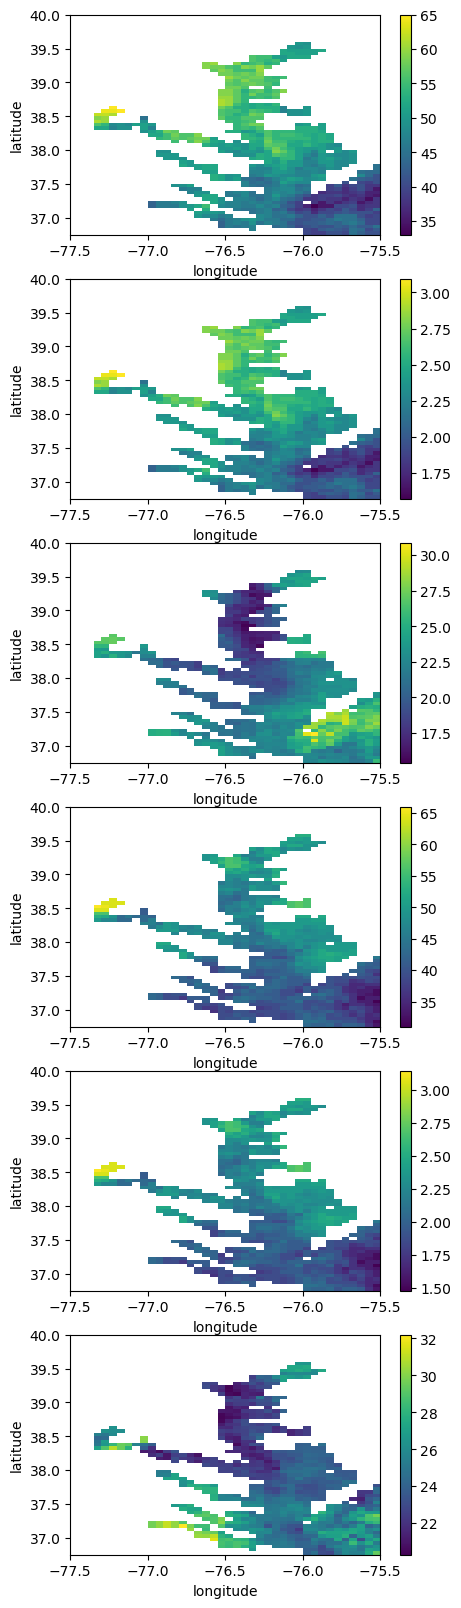

In [21]:
fig, axes = plt.subplots(6, 1, figsize=(5, 20))
for i, p in enumerate([no_occ_da, avg_annual_events_da, avg_cum_intensity_da, 
         no_occ_detr_da, avg_annual_events_detr_da, avg_cum_intensity_detr_da]):
    p.plot(ax=axes[i])

#### Non-detrended metadata

Number of Occurrences

In [22]:
# Spatial metadata
no_occ_da.rio.write_crs("epsg:4326", inplace=True)
avg_dur_da.rio.write_crs("epsg:4326", inplace=True)
avg_max_int_da.rio.write_crs("epsg:4326", inplace=True)
avg_mean_int_da.rio.write_crs("epsg:4326", inplace=True)
avg_rate_on_da.rio.write_crs("epsg:4326", inplace=True)
avg_rate_off_da.rio.write_crs("epsg:4326", inplace=True)
avg_annual_events_da.rio.write_crs("epsg:4326", inplace=True)
avg_cum_intensity_da.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray (latitude: 65, longitude: 40)>
array([[        nan,         nan,         nan, ..., 21.44564443,
        22.38255396, 25.82389431],
       [        nan,         nan,         nan, ..., 22.0505911 ,
        23.73941438, 23.59071334],
       [        nan,         nan,         nan, ..., 22.94574125,
        23.20270621, 21.78038958],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * latitude     (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude    (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
    spatial_ref  int64 0

In [23]:
# Add metadata
no_occ_da = no_occ_da.rename('total_no_occurrences').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of MHW', 'description': 
     "The total number of MHWs reported from EJO's MHW code for each pixel from " \
        "01/01/2003 to 12/31/2023" \
     "Passing along EJO's `n_events` metric. Processed with linearly detrended" \
     "SST ", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average Duration

In [24]:
# Add metadata
avg_dur_da = avg_dur_da.rename('avg_duration').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of days', 'description': "The average 'duration' " \
     "statistic reported from EJO's MHW code for each pixel, averaged over all of " \
     "the MHW identified in that pixel (01/01/2003-12/31/2023)", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')
    }
)

Average Max Intensity

In [25]:
# Add metadata
avg_max_int_da = avg_max_int_da.rename('avg_max_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the maximum intensity, " \
     "`intensity_max`, averaged over the full time series" \
     "(01/01/2003-12/31/2023)", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average Mean Intensity

In [26]:
# Add metadata
avg_mean_int_da = avg_mean_int_da.rename('avg_mean_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the mean intensity, " \
     "`intensity_mean`, averaged over the full time series " \
     "(01/01/2003-12/31/2023)", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average rate of onset

In [27]:
# Add metadata
avg_rate_on_da = avg_rate_on_da.rename('avg_onset_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
     "the MHW rate of onset (`rate_onset`), averaged over all MHW in the time series " \
     "(01/01/2003-12/31/2023)",
     'processing_date':  datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average rate of decline

In [28]:
# Add metadata
avg_rate_off_da = avg_rate_off_da.rename('avg_decline_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
    "the MHW rate of deline (`rate_decline`), averaged over all MHW in the time series " \
     "(01/01/2003-12/31/2023)",
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average number of annual events

In [29]:
# Add metadata
avg_annual_events_da = avg_annual_events_da.rename('avg_no_annual_events').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# MHW', 'description': "counts the number " \
     "of mhw in each year and returns the average number of MHW events per year" \
     "(01/01/2003-12/31/2023)", 
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average cumulative intensity

In [30]:
# Add metadata
avg_cum_intensity_da = avg_cum_intensity_da.rename('avg_cum_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C * day', 'description': "calculate the " \
     "cumulative intensity of all the mhw for each year and returns the average over " \
     "all the years"  \
     "(01/01/2003-12/31/2023)", 'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

#### Detrended metadata outputs

In [31]:
# Spatial metadata
no_occ_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_dur_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_max_int_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_mean_int_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_rate_on_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_rate_off_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_annual_events_detr_da.rio.write_crs("epsg:4326", inplace=True)
avg_cum_intensity_detr_da.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray (latitude: 65, longitude: 40)>
array([[        nan,         nan,         nan, ..., 25.47287639,
        27.46822206, 29.32555286],
       [        nan,         nan,         nan, ..., 24.88852976,
        27.15554499, 26.71500413],
       [        nan,         nan,         nan, ..., 24.96007358,
        25.62159359, 26.35557016],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * latitude     (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude    (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
    spatial_ref  int64 0

Number of Occurrences

In [32]:
# Add metadata
no_occ_detr_da = no_occ_detr_da.rename('total_no_occurrences').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of MHW', 'description': 
     "The total number of MHWs reported from EJO's MHW code for each pixel. " \
     "Passing along EJO's `n_events` metric. Processed with linearly detrended" \
     "SST for MHW calculation.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average Duration

In [33]:
# Add metadata
avg_dur_detr_da = avg_dur_detr_da.rename('avg_duration').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of days', 'description': "The 'duration' " \
     "statistic reported from EJO's MHW code for each pixel, averaged over all of " \
     "the MHW identified in that pixel. Processed with linearly detrended" \
     "SST for MHW calculation.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average Max Intensity

In [34]:
# Add metadata
avg_max_int_detr_da = avg_max_int_detr_da.rename('avg_max_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the maximum intensity, " \
     "`intensity_max`, averaged over the full time series. Processed with" \
     "linearly detrended SST for MHW calculation.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average Mean Intensity

In [35]:
# Add metadata
avg_mean_int_detr_da = avg_mean_int_detr_da.rename('avg_mean_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the mean intensity, " \
     "`intensity_mean`, averaged over the full time series. Processed with" \
     "linearly detrended SST for MHW calculation.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average rate of onset

In [36]:
# Add metadata
avg_rate_on_detr_da = avg_rate_on_detr_da.rename('avg_onset_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
     "the rate of onset of MHW (`rate_onset`), averaged over all MHW in the time" \
     "series. Processed with linearly detrended SST for MHW calculation.",
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average rate of decline

In [37]:
# Add metadata
avg_rate_off_detr_da = avg_rate_off_detr_da.rename('avg_decline_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
    "the rate of deline of MHW (`rate_decline`), averaged over all MHW in the" \
    "time series. Processed with linearly detrended SST for MHW calculation.",
    'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average number of annual events

In [38]:
# Add metadata
avg_annual_events_detr_da = avg_annual_events_detr_da.rename('avg_no_annual_events').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# MHW', 'description': "counts the number " \
     "of mhw in each year and returns the average number of MHW events per year."
     "Processed with linearly detrended SST for MHW calculation.", 
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

Average cumulative intensity

In [39]:
# Add metadata
avg_cum_intensity_detr_da = avg_cum_intensity_detr_da.rename('avg_cum_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C * day', 'description': "calculate"
     "the cumulative intensity of all the mhw for each year and returns the "
     "average over all the years. Processed with linearly detrended" \
     "SST for MHW calculation.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

### Save output

Non-detrended MHW outputs

In [40]:
# Combine data arrays into a single dataset
all_chars_ds = xr.merge([no_occ_da, avg_dur_da, avg_max_int_da, avg_rate_on_da, 
         avg_rate_off_da, avg_annual_events_da, avg_cum_intensity_da])

In [38]:
output_dir = REPO_ROOT / 'data/03_processed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [39]:
path = output_dir / 'mhw_average_characteristics.nc'

In [42]:
all_chars_ds.to_netcdf(output_dir / 'mhw_average_characteristics.nc')

In [43]:
all_chars_ds

<xarray.Dataset>
Dimensions:               (latitude: 65, longitude: 40)
Coordinates:
  * latitude              (latitude) float32 36.78 36.83 36.88 ... 39.92 39.97
  * longitude             (longitude) float32 -77.47 -77.43 ... -75.57 -75.53
    spatial_ref           int64 0
Data variables:
    total_no_occurrences  (latitude, longitude) float64 nan nan nan ... nan nan
    avg_duration          (latitude, longitude) float64 nan nan nan ... nan nan
    avg_max_intensity     (latitude, longitude) float64 nan nan nan ... nan nan
    avg_onset_rate        (latitude, longitude) float64 nan nan nan ... nan nan
    avg_decline_rate      (latitude, longitude) float64 nan nan nan ... nan nan
    avg_no_annual_events  (latitude, longitude) float64 nan nan nan ... nan nan
    avg_cum_intensity     (latitude, longitude) float64 nan nan nan ... nan nan
Attributes:
    source:           NOAA Geopolar
    unit:             # of MHW
    description:      The total number of MHWs reported from EJO's MHW code f...
    processing_date:  2025-04-17

Detrended MHW outputs

In [41]:
# Combine data arrays into a single dataset
all_chars_detr_ds = xr.merge([no_occ_detr_da, avg_dur_detr_da, avg_max_int_detr_da, avg_rate_on_detr_da, 
         avg_rate_off_detr_da, avg_annual_events_detr_da, avg_cum_intensity_detr_da])

In [45]:
all_chars_detr_ds.to_netcdf(output_dir / 'mhw_average_characteristics.nc')

## Plots

### Create the mask file for unvalidated tributaries

In [42]:
stem_gdf = gpd.read_file(REPO_ROOT / 'data/01_raw/BayTributaryFree.geojson')

In [43]:
geopolar.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'analysed_sst' (time: 7663, lat: 65, lon: 40)>
[19923800 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01T12:00:00 ... 2023-12-31T12:...
  * lat          (lat) float32 36.78 36.83 36.88 36.92 ... 39.88 39.92 39.97
  * lon          (lon) float32 -77.47 -77.43 -77.38 ... -75.62 -75.57 -75.53
    spatial_ref  int64 0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -200
    valid_max:      4000
    reference:      Fieguth,P.W. et al. "Mapping Mediterranean altimeter data...
    source:         STAR-ACSPO_GAC, STAR-ACSPO_H-8, STAR-Geo_SST, UKMO-OSTIA
    comment:        Analysed SST for each ocean grid point

In [44]:
mask = geopolar.isel(time=0).rio.clip(stem_gdf.geometry.values, stem_gdf.crs, 
                                         drop=False, invert=True).notnull()
mask = mask.where(mask==1, np.nan)

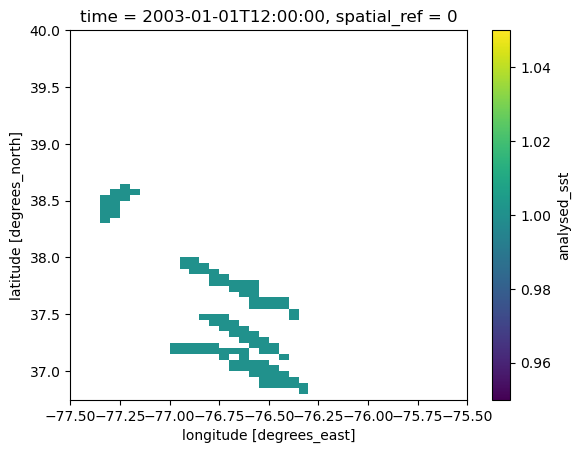

In [45]:
mask.plot()

### MHW Days

* hatch [styles](https://matplotlib.org/stable/gallery/shapes_and_collections/hatch_style_reference.html)

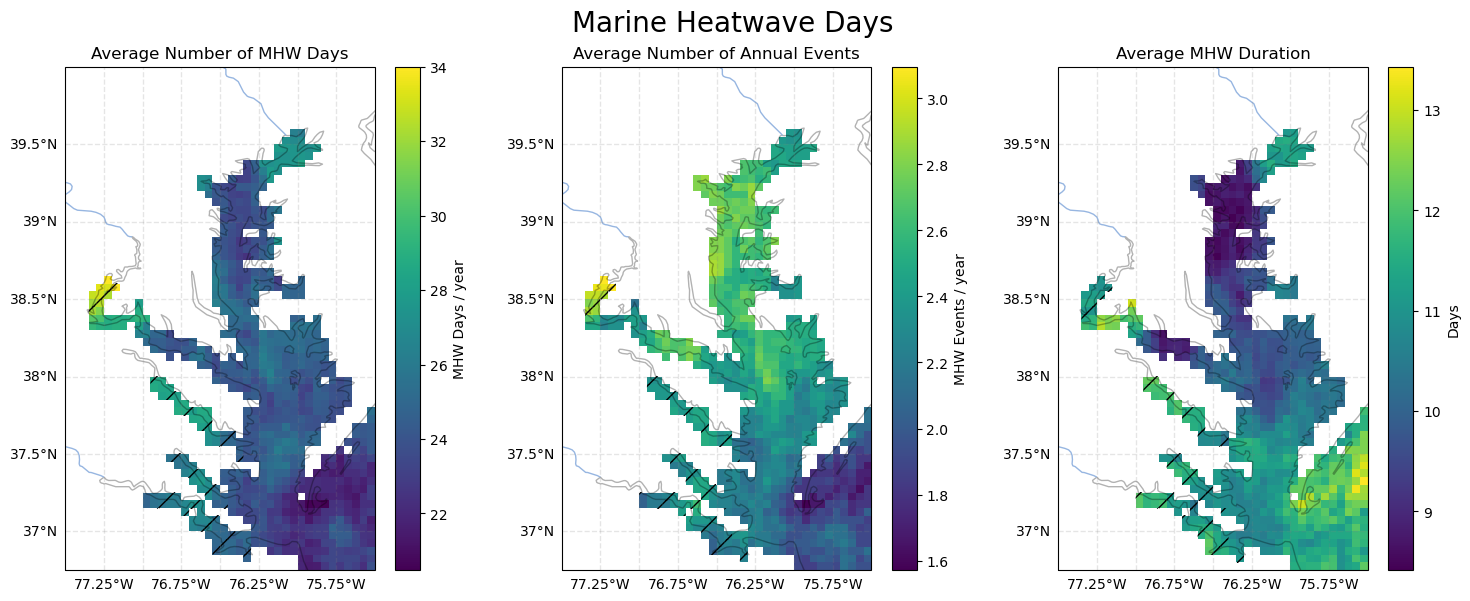

In [46]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(15, 6)
fig.suptitle('Marine Heatwave Days', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# no. of annual events and duration
cbar_unit = 'MHW Days / year'
(avg_annual_events_da * avg_dur_da).plot(ax=axes[0], cbar_kwargs={'label': cbar_unit})
axes[0].set_title('Average Number of MHW Days')

cbar_unit = 'MHW Events / year'
avg_annual_events_da.plot(ax=axes[1], cbar_kwargs={'label': cbar_unit},)
axes[1].set_title('Average Number of Annual Events')

cbar_unit = 'Days'
avg_dur_da.plot(ax=axes[2], cbar_kwargs={'label': cbar_unit},)
axes[2].set_title('Average MHW Duration')

# Add unvalidated tributary marker on top
for ax in axes.flatten():
    # Use pcolor with alpha set to 0 to get just crosshatch
    ax.pcolor(mask.lon.data, mask.lat.data, mask.data, shading='nearest', hatch='/', alpha=0., 
           transform=ccrs.PlateCarree())

fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/03_marineheatwaves' / 'average_mhw_days.png', 
                dpi=400, 
                bbox_inches='tight'
               )

### MHW Characteristics (4 remaining)

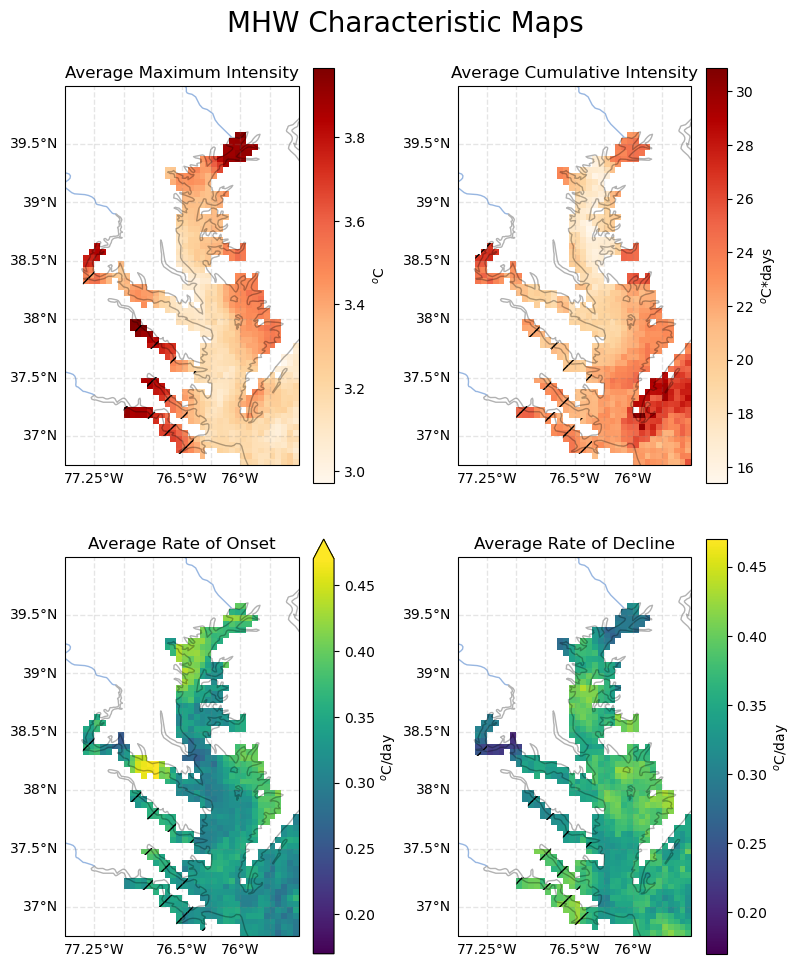

In [47]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 10)
fig.suptitle('MHW Characteristic Maps', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# # no. of annual events and duration
# cbar_unit = '# of MHW Events'
# avg_annual_events_da.plot(ax=axes[0, 0], cmap='GnBu', cbar_kwargs={'label': cbar_unit},)
# axes[0, 0].set_title('Average Number of Annual Events')
# cbar_unit = '# of Days'
# avg_dur_da.plot(ax=axes[0, 1], cmap='RdPu', cbar_kwargs={'label': cbar_unit},)
# axes[0, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
avg_max_int_da.plot(ax=axes[0, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[0, 0].set_title('Average Maximum Intensity')
cbar_unit = '$^o$C*days'
avg_cum_intensity_da.plot(ax=axes[0, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[0, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_da.plot(ax=axes[1, 0], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[1, 0].set_title('Average Rate of Onset')
cbar_unit = '$^o$C/day'
avg_rate_off_da.plot(ax=axes[1, 1], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Average Rate of Decline')

# Add unvalidated tributary marker on top
for ax in axes.flatten():
    # Use pcolor with alpha set to 0 to get just crosshatch
    ax.pcolor(mask.lon.data, mask.lat.data, mask.data, shading='nearest', hatch='/', alpha=0., 
           transform=ccrs.PlateCarree())

fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/03_marineheatwaves' / 'all_characteristics.png',
                dpi=400, bbox_inches='tight')


### A Big Group Photo - All 6 characteristics (Extra Plot)

Plotting all the characteristics together

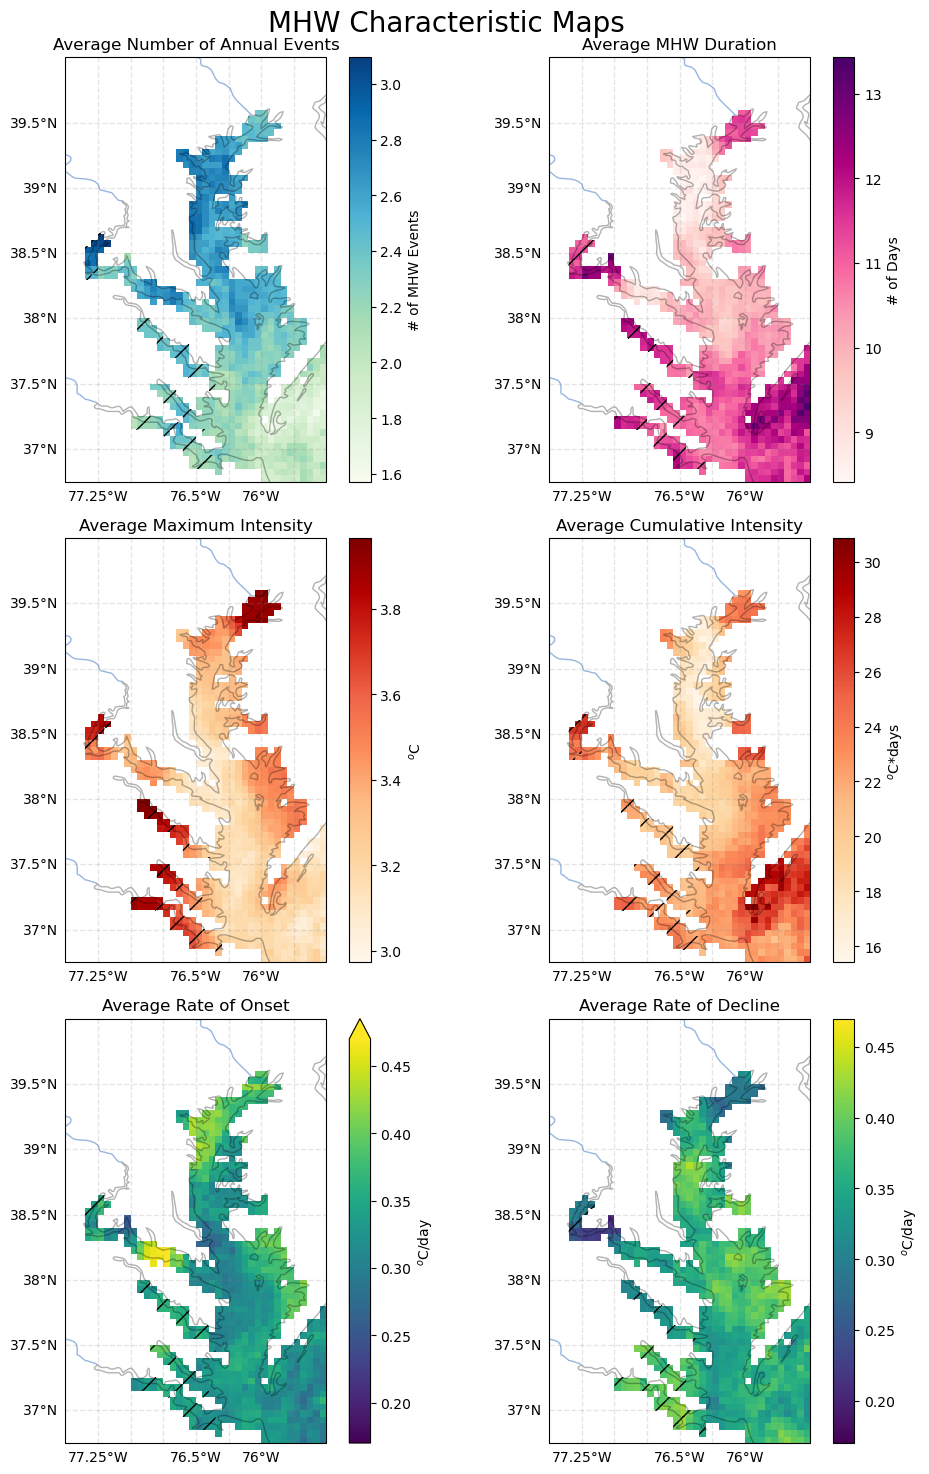

In [48]:
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 15)
fig.suptitle('MHW Characteristic Maps', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# no. of annual events and duration
cbar_unit = '# of MHW Events'
avg_annual_events_da.plot(ax=axes[0, 0], cmap='GnBu', cbar_kwargs={'label': cbar_unit},)
axes[0, 0].set_title('Average Number of Annual Events')
cbar_unit = '# of Days'
avg_dur_da.plot(ax=axes[0, 1], cmap='RdPu', cbar_kwargs={'label': cbar_unit},)
axes[0, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
avg_max_int_da.plot(ax=axes[1, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[1, 0].set_title('Average Maximum Intensity')
cbar_unit = '$^o$C*days'
avg_cum_intensity_da.plot(ax=axes[1, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[1, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_da.plot(ax=axes[2, 0], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[2, 0].set_title('Average Rate of Onset')
cbar_unit = '$^o$C/day'
avg_rate_off_da.plot(ax=axes[2, 1], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[2, 1].set_title('Average Rate of Decline')

# Add unvalidated tributary marker on top
for ax in axes.flatten():
    # Use pcolor with alpha set to 0 to get just crosshatch
    ax.pcolor(mask.lon.data, mask.lat.data, mask.data, shading='nearest', hatch='/', alpha=0., 
           transform=ccrs.PlateCarree())

fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'data_archive/all_characteristics.png', dpi=400, 
                bbox_inches='tight')


## Comparing with Regular MHW Analysis

### Fixed vs. Shifting Baseline Number of events

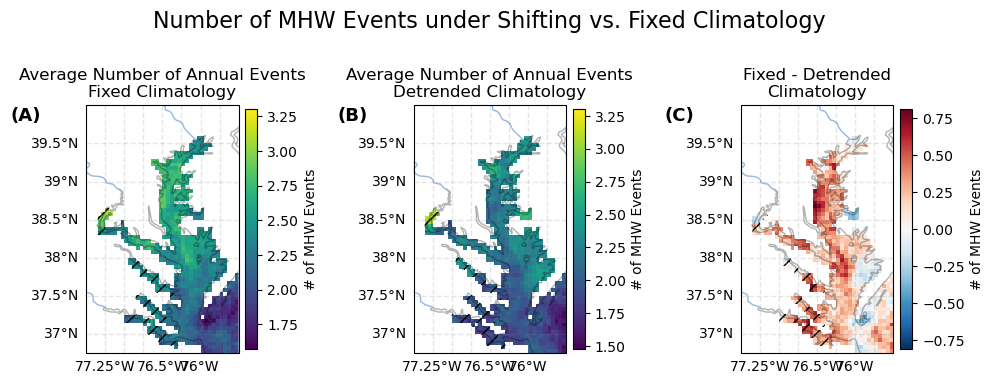

In [49]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 4)
fig.suptitle('Number of MHW Events under Shifting vs. Fixed Climatology', size=16)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

    ax.pcolor(mask.lon.data, mask.lat.data, mask.data, shading='nearest', hatch='/', alpha=0., 
               transform=ccrs.PlateCarree())


cbar_unit = '# of MHW Events'
im0 = avg_annual_events_da.plot(ax=axes[0], add_colorbar=False, vmax=3.3)
axes[0].set_title('Average Number of Annual Events\nFixed Climatology')
plt.colorbar(im0, fraction=0.07, pad=0.04, label=cbar_unit)

im1 = avg_annual_events_detr_da.plot(ax=axes[1], add_colorbar=False, vmax=3.3)
axes[1].set_title('Average Number of Annual Events\nDetrended Climatology')
plt.colorbar(im1, fraction=0.07, pad=0.04, label=cbar_unit)

# Full MHW Calc - Detrended: looking at MHW characteristics due to shift
# in extreme values
# no. of annual events and duration
im2 = (avg_annual_events_da - avg_annual_events_detr_da).plot(ax=axes[2], add_colorbar=False)
axes[2].set_title('Fixed - Detrended\nClimatology')
plt.colorbar(im2, fraction=0.07, pad=0.04, label=cbar_unit)

# Add unvalidated tributary marker on top
for ax in axes.flatten():
    # Use pcolor with alpha set to 0 to get just crosshatch
    ax.pcolor(mask.lon.data, mask.lat.data, mask.data, shading='nearest', hatch='//', alpha=0., 
           transform=ccrs.PlateCarree())

# Add labels
axes[0].text(-78.5, 39.8, '(A)', weight='bold', size=13)
axes[1].text(-78.5, 39.8, '(B)', weight='bold', size=13)
axes[2].text(-78.5, 39.8, '(C)', weight='bold', size=13)


fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/03_marineheatwaves' / 'fixed_detrended_comparison_numevents.png', 
        dpi=400,
        bbox_inches='tight'
    )

### Extra plots

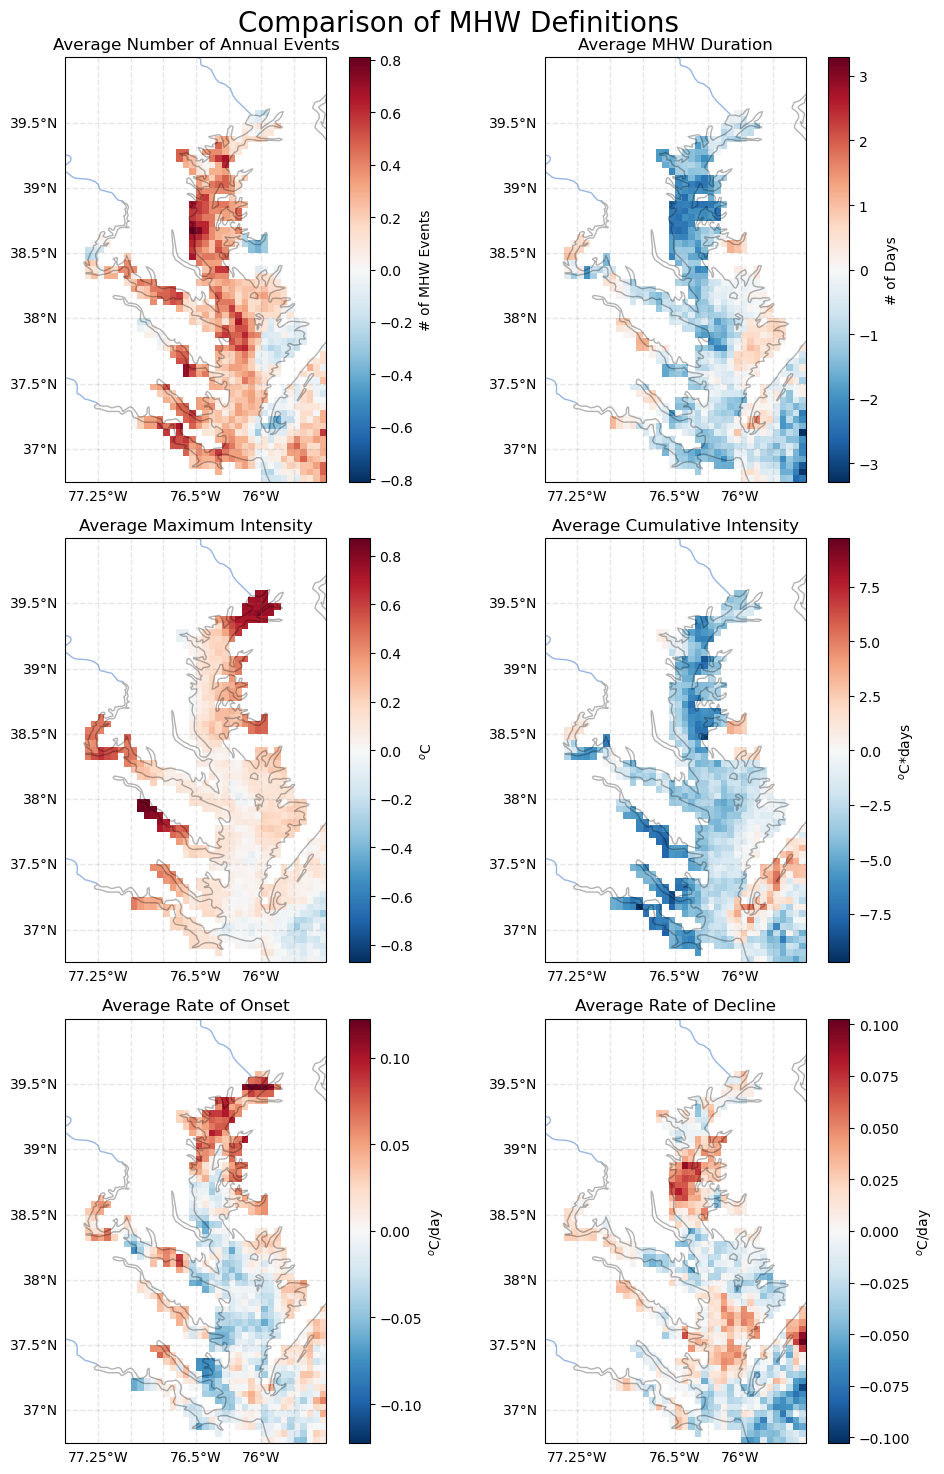

In [51]:
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 15)
fig.suptitle('Comparison of MHW Definitions', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Full MHW Calc - Detrended: looking at MHW characteristics due to shift
# in extreme values
# no. of annual events and duration
cbar_unit = '# of MHW Events'
(avg_annual_events_da - avg_annual_events_detr_da).plot(ax=axes[0, 0], cbar_kwargs={'label': cbar_unit},)
axes[0, 0].set_title('Average Number of Annual Events')
cbar_unit = '# of Days'
(avg_dur_da - avg_dur_detr_da).plot(ax=axes[0, 1], cbar_kwargs={'label': cbar_unit},)
axes[0, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
(avg_max_int_da - avg_max_int_detr_da).plot(ax=axes[1, 0], cbar_kwargs={'label': cbar_unit},)
axes[1, 0].set_title('Average Maximum Intensity')
cbar_unit = '$^o$C*days'
(avg_cum_intensity_da - avg_cum_intensity_detr_da).plot(ax=axes[1, 1], cbar_kwargs={'label': cbar_unit},)
axes[1, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
(avg_rate_on_da - avg_rate_on_detr_da).plot(ax=axes[2, 0], cbar_kwargs={'label': cbar_unit})
axes[2, 0].set_title('Average Rate of Onset')
cbar_unit = '$^o$C/day'
(avg_rate_off_da - avg_rate_off_detr_da).plot(ax=axes[2, 1], cbar_kwargs={'label': cbar_unit})
axes[2, 1].set_title('Average Rate of Decline')

fig.tight_layout()

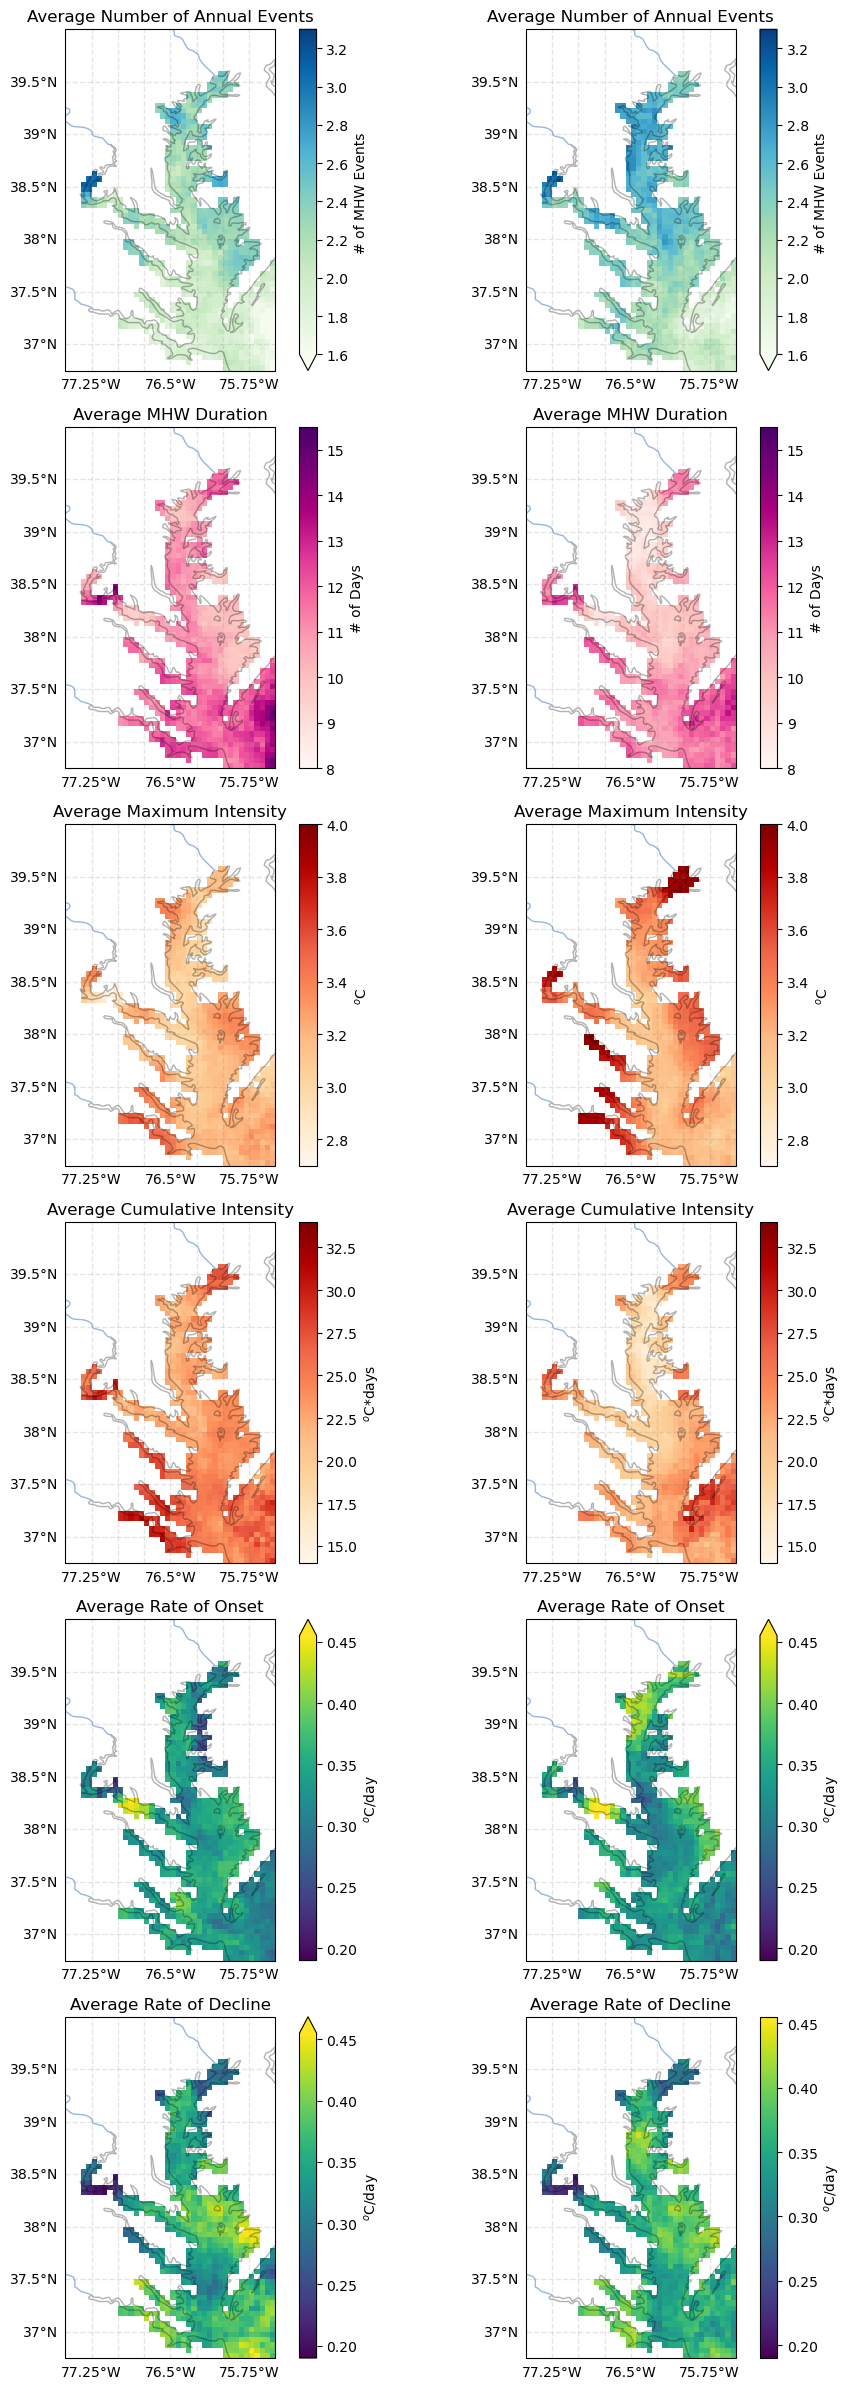

In [53]:
fig, axes = plt.subplots(6, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 24)
# fig.suptitle('MHW Characteristic Maps', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Full MHW Calc - Detrended: looking at MHW characteristics due to shift
# in extreme values
# no. of annual events and duration
cbar_unit = '# of MHW Events'
avg_annual_events_detr_da.plot(ax=axes[0, 0], cmap='GnBu', cbar_kwargs={'label': cbar_unit},
                         vmin=1.6, vmax=3.3)
axes[0, 0].set_title('Average Number of Annual Events')

cbar_unit = '# of MHW Events'
avg_annual_events_da.plot(ax=axes[0, 1], cmap='GnBu', cbar_kwargs={'label': cbar_unit},
                  vmin=1.6, vmax=3.3)
axes[0, 1].set_title('Average Number of Annual Events')

cbar_unit = '# of Days'
avg_dur_detr_da.plot(ax=axes[1, 0], cmap='RdPu', cbar_kwargs={'label': cbar_unit},
                vmin=8, vmax=15.5)
axes[1, 0].set_title('Average MHW Duration')

cbar_unit = '# of Days'
avg_dur_da.plot(ax=axes[1, 1], cmap='RdPu', cbar_kwargs={'label': cbar_unit},
              vmin=8, vmax=15.5)
axes[1, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
avg_max_int_detr_da.plot(ax=axes[2, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},
                    vmin=2.7, vmax=4.0)
axes[2, 0].set_title('Average Maximum Intensity')

cbar_unit = '$^o$C'
avg_max_int_da.plot(ax=axes[2, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},
          vmin=2.7, vmax=4.0)
axes[2, 1].set_title('Average Maximum Intensity')

cbar_unit = '$^o$C*days'
avg_cum_intensity_detr_da.plot(ax=axes[3, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},
                          vmin=14, vmax=34)
axes[3, 0].set_title('Average Cumulative Intensity')

cbar_unit = '$^o$C*days'
avg_cum_intensity_da.plot(ax=axes[3, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},
             vmin=14, vmax=34)
axes[3, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_detr_da.plot(ax=axes[4, 0], cbar_kwargs={'label': cbar_unit},
                    vmin=0.19, vmax=0.455)
axes[4, 0].set_title('Average Rate of Onset')

cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_da.plot(ax=axes[4, 1], cbar_kwargs={'label': cbar_unit},
             vmin=0.19, vmax=0.455)
axes[4, 1].set_title('Average Rate of Onset')

cbar_unit = '$^o$C/day'
avg_rate_off_detr_da.plot(ax=axes[5, 0], cbar_kwargs={'label': cbar_unit},
                     vmin=0.19, vmax=0.455)
axes[5, 0].set_title('Average Rate of Decline')

cbar_unit = '$^o$C/day'
avg_rate_off_da.plot(ax=axes[5, 1], cbar_kwargs={'label': cbar_unit},
              vmin=0.19, vmax=0.455)
axes[5, 1].set_title('Average Rate of Decline')

fig.tight_layout()
